# Langchain Demo

## Part I. Manual Steps

In [1]:
# This might take you a little bit of sorting packages! We use langchain-openai!
#!pip install -U langchain-core langchain langchain-openai

In [2]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [3]:
"""
Load the OpenAI API key from a local .env file and verify it is available.

What this cell does:
- Calls load_dotenv() to read environment variables from a .env file in the current directory
  (or nearest parent directory, depending on python-dotenv behavior).
- Reads OPENAI_API_KEY from the environment.
- Prints a success message if the key is present, otherwise raises an error.
"""

from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
if api_key and api_key.strip():
    print("✅ OK: OPENAI_API_KEY loaded from .env")
else:
    raise AssertionError("❌ OPENAI_API_KEY not found in .env file!")

✅ OK: OPENAI_API_KEY loaded from .env


In [4]:
"""
Minimal LangChain example

What this cell does:
- Creates a PromptTemplate
- Formats it with variables
- Sends it directly to the LLM via invoke()
"""

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Define prompt template
prompt = PromptTemplate(
    input_variables=["x"],
    template="Write Python code defining a polynomial function of mixed degree f(x) and normalize such that |f(x)| < 10 on [-10,10]."
)

# Format prompt
formatted_prompt = prompt.format(x=3)

# Call LLM
response = llm.invoke(formatted_prompt)

print("LLM response:\n")
print(response.content)


LLM response:

To define a polynomial function of mixed degree and normalize it such that its absolute value is less than 10 on the interval \([-10, 10]\), we can follow these steps:

1. Define the polynomial function.
2. Evaluate the polynomial over the specified range.
3. Find the maximum absolute value of the polynomial over that range.
4. Normalize the polynomial by dividing it by this maximum value and scaling it to ensure it stays within the desired bounds.

Here's a Python code snippet that accomplishes this:

```python
import numpy as np
import matplotlib.pyplot as plt

# Define the polynomial function of mixed degree
def f(x):
    # Example polynomial: f(x) = 2x^3 - 3x^2 + 5x - 7
    return 2 * x**3 - 3 * x**2 + 5 * x - 7

# Define the range for x
x_values = np.linspace(-10, 10, 1000)

# Evaluate the polynomial
y_values = f(x_values)

# Find the maximum absolute value of the polynomial
max_abs_value = np.max(np.abs(y_values))

# Normalize the polynomial
def normalized_f(x):
  

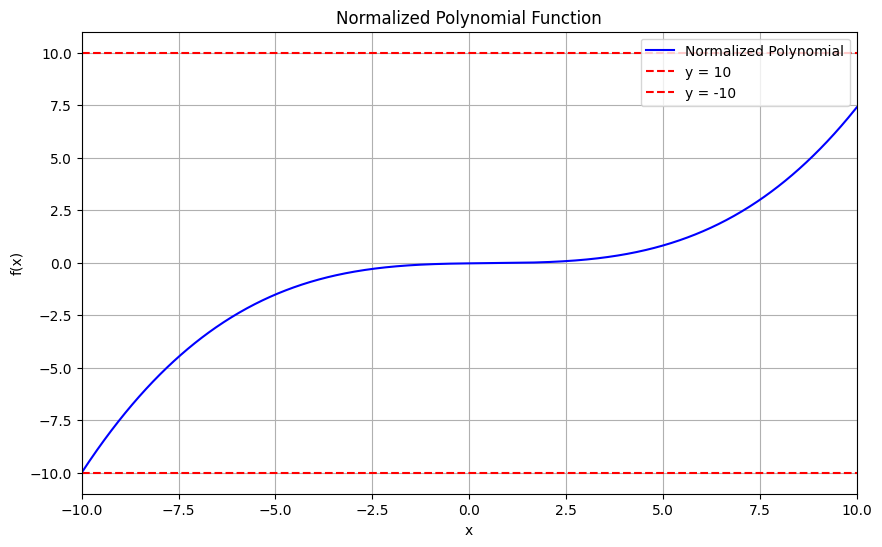

✅ OK: Generated code executed successfully.


In [5]:
"""
Extract Python code from an LLM response, save it to a file, and execute it.

What this cell does:
1. Takes the text output of an LLM response (response.content).
2. Strips surrounding explanations if the model wrapped the code in Markdown
   code fences (``` or ```python).
3. Writes the extracted Python code to a file.
4. Executes the file in the current Python process so that defined functions
   (e.g. f(x)) become available in the global namespace.
5. Reports success or prints a full traceback on failure.

This pattern is typical for LLM-based coding agents with human or automated
error inspection.
"""

import traceback

# Raw text returned by the LLM (modern LangChain API)
raw_content = response.content.strip()

# Extract Python code from Markdown fences if present
if "```python" in raw_content:
    code_lines = raw_content.split("```python", 1)[1].split("```", 1)[0]
elif "```" in raw_content:
    code_lines = raw_content.split("```", 1)[1].split("```", 1)[0]
else:
    # Fallback: assume the entire response is code
    code_lines = raw_content

# Save extracted code to file
filename = "f_function.py"
with open(filename, "w") as f:
    f.write(code_lines.strip())

# Execute the generated code
try:
    exec(open(filename).read(), globals())  # makes f(x) available globally
    print("✅ OK: Generated code executed successfully.")
except Exception:
    print("❌ Error while executing the generated code:")
    print(traceback.format_exc())


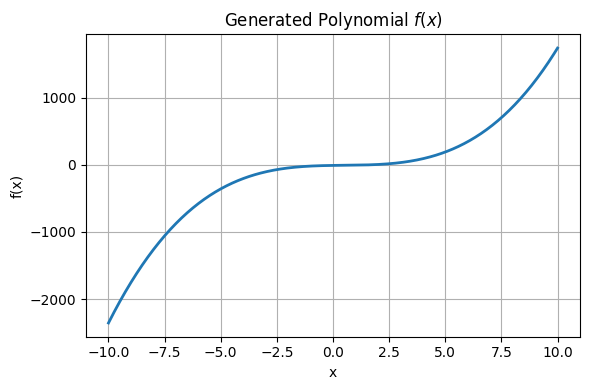

In [6]:
"""
Test and visualize the generated function f(x).

What this cell does:
1. Assumes that a function f(x) has already been defined and loaded
   into the global namespace by executing LLM-generated code.
2. Evaluates f(x) on a dense grid over the interval [-10, 10].
3. Plots the resulting curve using matplotlib.
4. Provides a quick sanity check on shape, smoothness, and magnitude.

This step is essential for validating LLM-generated numerical code:
visual inspection often reveals errors that do not raise exceptions.
"""

import numpy as np
import matplotlib.pyplot as plt

# Evaluation grid
x = np.linspace(-10, 10, 400)

# Evaluate generated function
y = f(x)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x, y, lw=2)
plt.title("Generated Polynomial $f(x)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()
plt.show()

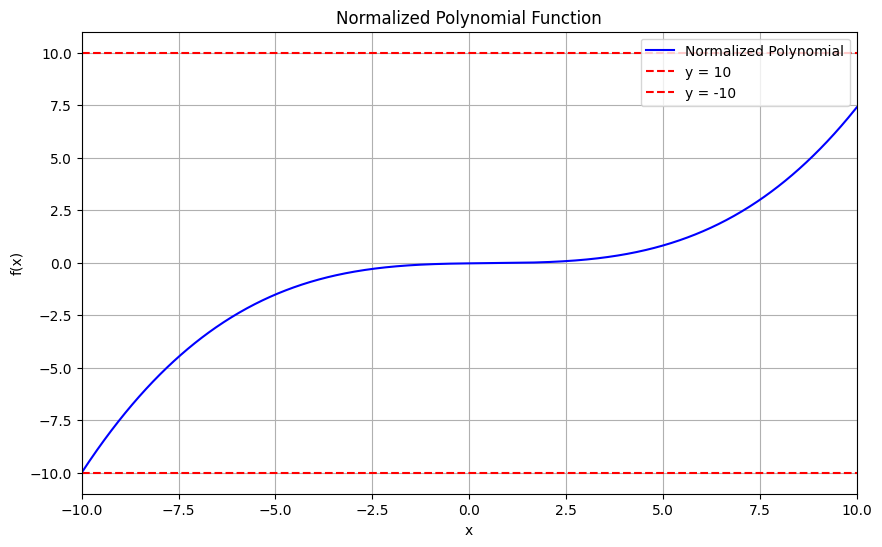

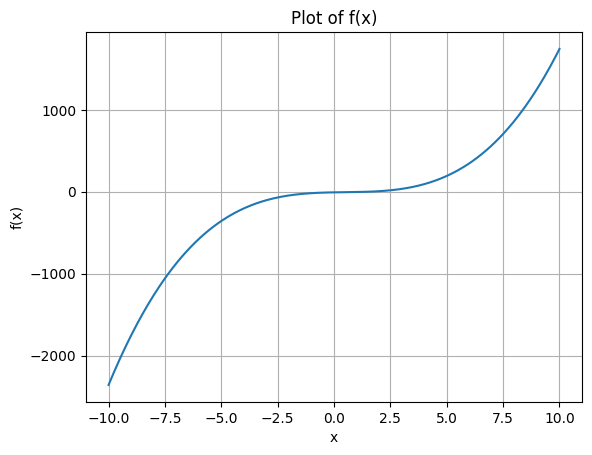

✅ OK: Plot generated successfully (plot.png).


In [7]:
"""
Ask an LLM to generate plotting code for an already-defined function f(x),
save that code to a file, and execute it to produce a plot.

What this cell does:
1. Uses a PromptTemplate to instruct the LLM to write plotting code only.
   - f(x) is assumed to already exist (must NOT be redefined).
   - The output must be pure Python code.
2. Sends the prompt to the LLM using the modern LangChain invoke() pattern.
3. Extracts Python code from the LLM response, removing Markdown fences if present.
4. Saves the generated code to 'plot_function.py'.
5. Executes both:
   - the previously generated function definition (f_function.py)
   - the generated plotting script
6. Reports success or prints a full traceback on failure.

This demonstrates a second agent step:
LLM-generated code operating on LLM-generated code.
"""

import traceback
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

# Initialize LLM (if not already done)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt instructing the LLM to generate plotting code only
prompt_plot = PromptTemplate.from_template(
    """
Given a function f(x) which is already defined and available,
do NOT define f(x) again.

Write a Python script that:
- evaluates f(x) on x in [-10, 10]
- plots the result using matplotlib
- saves the figure as 'plot.png'

Return Python code only. No markdown. No explanations.
"""
)

# Invoke the LLM
response = llm.invoke(prompt_plot.format())

# Raw LLM output
raw_content = response.content.strip()

# Extract Python code from Markdown fences if present
if "```python" in raw_content:
    code_lines = raw_content.split("```python", 1)[1].split("```", 1)[0]
elif "```" in raw_content:
    code_lines = raw_content.split("```", 1)[1].split("```", 1)[0]
else:
    code_lines = raw_content  # fallback

# Save generated plotting code
plot_filename = "plot_function.py"
with open(plot_filename, "w") as f:
    f.write(code_lines.strip())

# Execute function definition and plotting code
try:
    exec(open("f_function.py").read(), globals())
    exec(open(plot_filename).read(), globals())
    print("✅ OK: Plot generated successfully (plot.png).")
except Exception:
    print("❌ Error during execution:")
    print(traceback.format_exc())


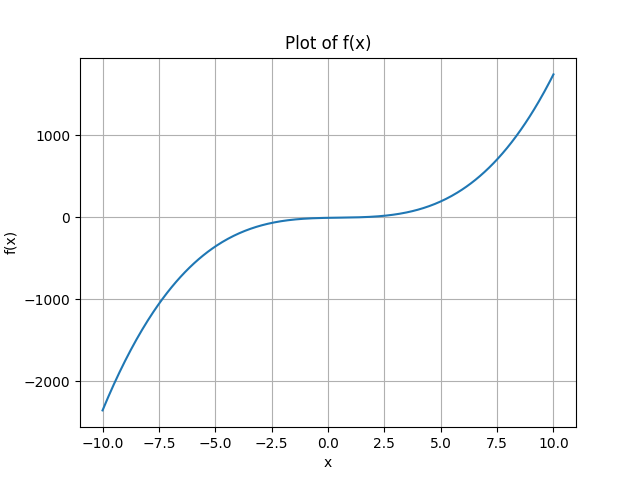

✅ OK: plot.png displayed.


In [8]:
"""
Display the generated plot image if it exists.

What this cell does:
- Checks whether the file 'plot.png' was created by the previously executed
  LLM-generated plotting code.
- If the file exists, displays it inline in the Jupyter notebook.
- If the file is missing, prints a clear error message.

This step provides immediate visual feedback and confirms that the
LLM-generated plotting script executed successfully end-to-end.
"""

import os
from IPython.display import Image, display

# Show the resulting image if it exists
plot_file = "plot.png"

if os.path.exists(plot_file):
    display(Image(filename=plot_file, width=500))
    print("✅ OK: plot.png displayed.")
else:
    print("❌ plot.png not found.")

In [9]:
"""
Load the generated Python function code from file and ask the LLM to analyze it.

What this cell does:
1. Reads the contents of 'f_function.py', which was previously generated
   by the LLM and executed.
2. Uses the loaded source code as explicit input to a PromptTemplate.
3. Asks the LLM to describe mathematical properties of the function
   (degree, extrema, monotonicity).
4. Displays the analysis as Markdown.

This avoids relying on in-memory variables and makes the workflow
file-based, reproducible, and inspectable.
"""

from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown, display

# Load function code from file
with open("f_function.py", "r") as f:
    function_code = f.read()

# Build prompt for mathematical analysis
prompt_summary = PromptTemplate.from_template(
    """
Given the following Python function definition:

{code}

Describe the mathematical properties of this function:
- degree (if polynomial)
- local maxima and minima
- monotonicity intervals
"""
)

# Invoke the LLM
summary_response = llm.invoke(
    prompt_summary.format(code=function_code)
)

# Display result
print("🧠 Function Summary:\n")
display(Markdown(summary_response.content))

🧠 Function Summary:



The given function \( f(x) = 2x^3 - 3x^2 + 5x - 7 \) is a polynomial function. Let's analyze its mathematical properties:

### 1. Degree
The degree of a polynomial is the highest power of the variable \( x \) in the polynomial expression. In this case, the highest power of \( x \) is 3 (from the term \( 2x^3 \)). Therefore, the degree of the polynomial \( f(x) \) is **3**.

### 2. Local Maxima and Minima
To find the local maxima and minima, we need to compute the first derivative of the function and set it to zero to find critical points.

#### First Derivative
The first derivative of \( f(x) \) is:
\[
f'(x) = \frac{d}{dx}(2x^3 - 3x^2 + 5x - 7) = 6x^2 - 6x + 5
\]

#### Setting the First Derivative to Zero
To find critical points, we solve:
\[
6x^2 - 6x + 5 = 0
\]
Using the quadratic formula \( x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} \):
- Here, \( a = 6 \), \( b = -6 \), and \( c = 5 \).
- The discriminant \( b^2 - 4ac = (-6)^2 - 4 \cdot 6 \cdot 5 = 36 - 120 = -84 \).

Since the discriminant is negative, there are no real roots for the first derivative. This means that \( f'(x) \) does not change sign, indicating that there are no local maxima or minima. 

### 3. Monotonicity Intervals
Since the first derivative \( f'(x) = 6x^2 - 6x + 5 \) is a quadratic function that opens upwards (as the coefficient of \( x^2 \) is positive) and has no real roots, it is always positive. This implies that:

- The function \( f(x) \) is **increasing** for all \( x \in \mathbb{R} \).

### Summary
- **Degree**: 3
- **Local Maxima and Minima**: None (no critical points)
- **Monotonicity Intervals**: The function is increasing on the entire real line \( (-\infty, \infty) \). 

This means that as \( x \) increases, \( f(x) \) also increases without bound.

## Part II. Automatic Framework

In [10]:
"""
Autonomous LLM-based code agent with self-correcting execution loop.

What this code does:
1. Takes a high-level task description in natural language.
2. Prompts an LLM to generate a complete Python script for that task.
3. Saves the generated code to a file.
4. Executes the code in an isolated global namespace.
5. If execution fails, captures the full traceback and feeds it back
   into the prompt for automatic correction.
6. Repeats this process up to a fixed number of attempts.

This is a minimal but complete example of a self-correcting coding agent:
- The LLM generates code
- The system executes and evaluates it
- Errors drive the next decision
"""

import traceback
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown, display

# Initialize LLM (deterministic behavior)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def autonomous_code_agent(task_prompt, filename="generated.py", max_attempts=5):
    """
    Run a self-correcting LLM code generation loop.

    Parameters
    ----------
    task_prompt : str
        Natural-language description of the coding task.
    filename : str
        File where generated code is written.
    max_attempts : int
        Maximum number of generation–execution attempts.

    Returns
    -------
    success : bool
        True if code executed successfully.
    code : str or None
        Final generated code, or None if all attempts failed.
    """

    base_prompt = PromptTemplate.from_template(
        """
You are an expert Python coder.

Write a complete, executable Python script that performs the following task:

{task}

Constraints:
- Output Python code only
- No markdown
- No explanations
"""
    )

    current_prompt = base_prompt.format(task=task_prompt)

    for attempt in range(1, max_attempts + 1):
        print(f"\n=== Attempt {attempt} ===")

        # Invoke LLM
        response = llm.invoke(current_prompt)
        code = response.content.strip()

        # Save generated code
        with open(filename, "w") as f:
            f.write(code)

        # Display generated code for inspection
        display(Markdown(f"```python\n{code}\n```"))

        # Try executing the generated script
        try:
            exec_globals = {}
            exec(open(filename).read(), exec_globals)
            print("✅ OK: Code executed successfully.")
            return True, code

        except Exception:
            tb = traceback.format_exc()
            print("❌ Execution failed. Feeding error back to LLM.")
            current_prompt += (
                "\n\nThe last script failed with the following error:\n"
                f"{tb}\n\nPlease fix the code and generate a corrected version."
            )

    print("❌ Failed after maximum number of attempts.")
    return False, None



=== Attempt 1 ===


```python
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the polynomial function
def polynomial_function(x, y):
    return x**3 - 3*x*y**2 + 2*y**3

# Create a grid of points
x = np.linspace(-5, 5, 100)
y = np.linspace(-6, 6, 100)
x, y = np.meshgrid(x, y)
z = polynomial_function(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Save the plot
plt.savefig('my2d.png')
plt.show()
```

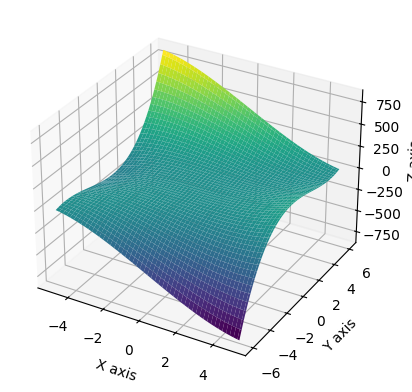

✅ OK: Code executed successfully.

Result: ✅ success


In [12]:
"""
Example call: ask the autonomous code agent to generate and execute a script
that creates a 3D visualization of a 2D polynomial over a specified domain.

Expected behavior:
- The agent generates a Python script.
- The script computes f(x, y) on a grid over [-5, 5] × [-6, 6].
- The script renders a plot (e.g., surface plot) using matplotlib.
- The plot is saved as 'my2d.png'.

Note:
- If the first generated script fails, the agent will retry automatically
  with traceback feedback (up to max_attempts).
"""

success, code = autonomous_code_agent(
    """
Create and make a 3d visualization of a 2d polynomial function of degree >=3 on the area
[-5,5]x[-6,6]. Save the plot as my2d.png.
""",
    filename="my2d_plot.py",
    max_attempts=5
)

print("\nResult:", "✅ success" if success else "❌ failed")

# We can run this code agent independently in a sandbox!